<a href="https://colab.research.google.com/github/mahalaxmy/NLP/blob/main/cbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re
import collections
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import jieba


In [2]:
# Sample Chinese documents
documents = [
"这是一个例子。",
"我们学习中文。",
"自然语言处理很有趣。"
]

            # Tokenize the documents
tokenized_docs = [list(jieba.cut(doc)) for doc in documents]
print("Tokenized Documents:", tokenized_docs)


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.925 seconds.
DEBUG:jieba:Loading model cost 0.925 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


Tokenized Documents: [['这是', '一个', '例子', '。'], ['我们', '学习', '中文', '。'], ['自然语言', '处理', '很', '有趣', '。']]


In [3]:
# Flatten the list of tokenized words and build the vocabulary
words = [word for doc in tokenized_docs for word in doc]
vocab = collections.Counter(words)
vocab_size = len(vocab)

# Create word to index and index to word mappings
word_to_idx = {word: i for i, (word, _) in enumerate(vocab.items())}
idx_to_word = {i: word for word, i in word_to_idx.items()}

# Generate training pairs
context_window = 2

def generate_context_target_pairs(tokenized_docs, context_window):
    context_target_pairs = []
    for doc in tokenized_docs:
        for i in range(len(doc)):
            target = doc[i]
            context = doc[max(0, i - context_window):i] + doc[i + 1:min(len(doc), i + context_window + 1)]
            context_target_pairs.append((context, target))
    return context_target_pairs

context_target_pairs = generate_context_target_pairs(tokenized_docs, context_window)
print("Context-Target Pairs:", context_target_pairs)



Context-Target Pairs: [(['一个', '例子'], '这是'), (['这是', '例子', '。'], '一个'), (['这是', '一个', '。'], '例子'), (['一个', '例子'], '。'), (['学习', '中文'], '我们'), (['我们', '中文', '。'], '学习'), (['我们', '学习', '。'], '中文'), (['学习', '中文'], '。'), (['处理', '很'], '自然语言'), (['自然语言', '很', '有趣'], '处理'), (['自然语言', '处理', '有趣', '。'], '很'), (['处理', '很', '。'], '有趣'), (['很', '有趣'], '。')]


In [4]:
# Convert context and target words to indices
def context_target_to_indices(context_target_pairs, word_to_idx):
    data = []
    for context, target in context_target_pairs:
        context_indices = [word_to_idx[word] for word in context]
        target_index = word_to_idx[target]
        data.append((context_indices, target_index))
    return data

data = context_target_to_indices(context_target_pairs, word_to_idx)
print("Data (context indices, target index):", data)


Data (context indices, target index): [([1, 2], 0), ([0, 2, 3], 1), ([0, 1, 3], 2), ([1, 2], 3), ([5, 6], 4), ([4, 6, 3], 5), ([4, 5, 3], 6), ([5, 6], 3), ([8, 9], 7), ([7, 9, 10], 8), ([7, 8, 10, 3], 9), ([8, 9, 3], 10), ([9, 10], 3)]


In [5]:
class CBOWModel(nn.Module):
      def __init__(self, vocab_size, embedding_dim):
          super(CBOWModel, self).__init__()
          self.embeddings = nn.Embedding(vocab_size, embedding_dim)
          self.linear1 = nn.Linear(embedding_dim, 128)
          self.linear2 = nn.Linear(128, vocab_size)

      def forward(self, context_words):
          embeds = sum(self.embeddings(context_words)).view(1, -1)
          out = F.relu(self.linear1(embeds))
          out = self.linear2(out)
          log_probs = F.log_softmax(out, dim=1)
          return log_probs

embedding_dim = 100
model = CBOWModel(vocab_size, embedding_dim)


In [9]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Prepare data for training
def make_context_vector(context, word_to_idx):
    idxs = [word_to_idx.get(w,0)   for w in context]



    return torch.tensor(idxs, dtype=torch.long)

        # Train the model
for epoch in range(100):
    total_loss = 0
    for context, target in data:
        context_vector = make_context_vector(context, word_to_idx)
        target = torch.tensor([target], dtype=torch.long)

                                                # Forward pass
        log_probs = model(context_vector)

                                                                        # Compute loss, backpropagate, and update weights
        loss = loss_fn(log_probs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
if epoch % 10 == 0:
   print(f"Epoch {epoch}, Loss: {total_loss}")

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36825 (\N{CJK UNIFIED IDEOGRAPH-8FD9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


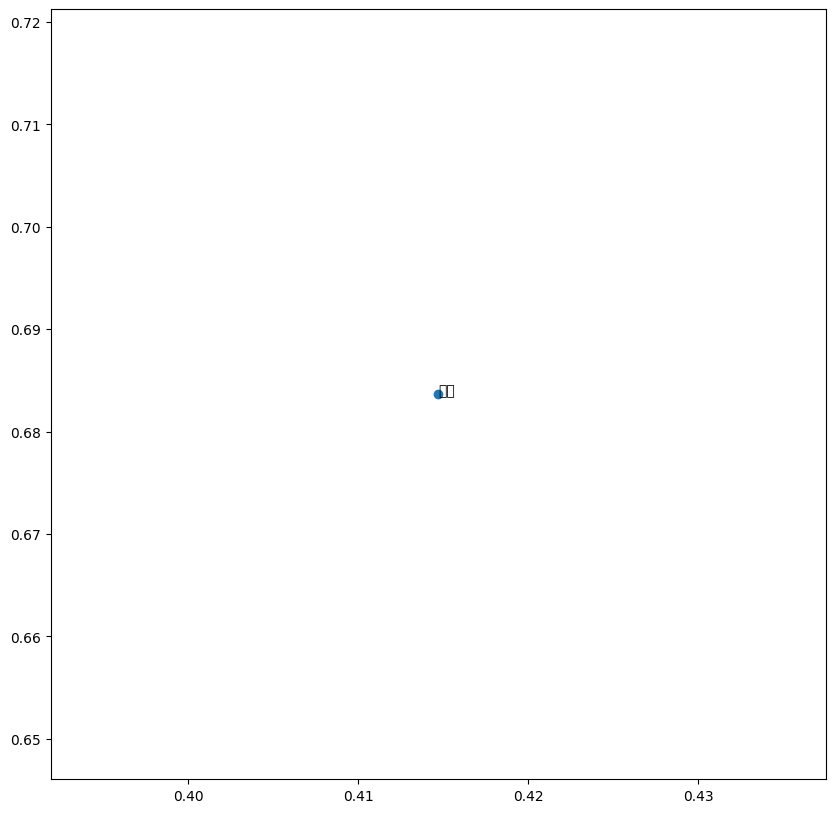

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


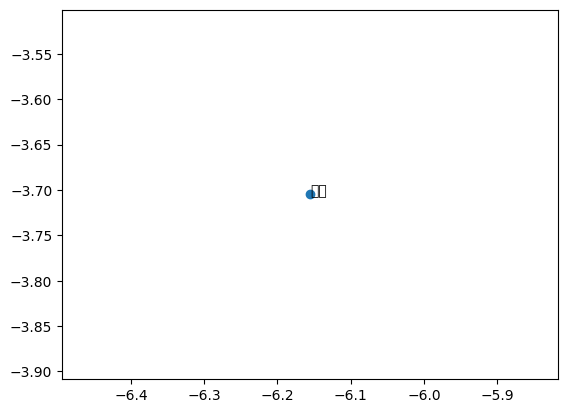

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


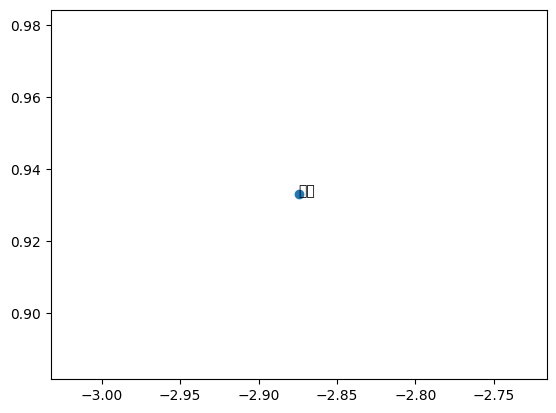

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12290 (\N{IDEOGRAPHIC FULL STOP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


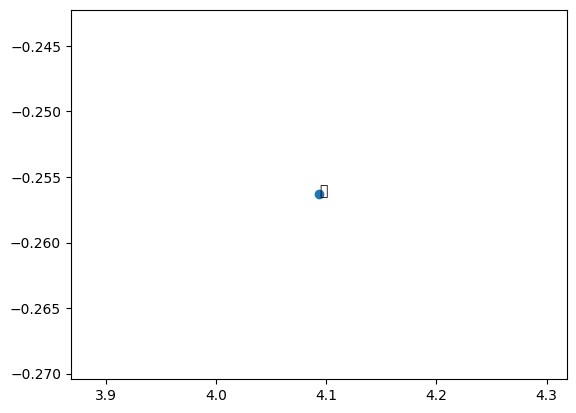

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25105 (\N{CJK UNIFIED IDEOGRAPH-6211}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20204 (\N{CJK UNIFIED IDEOGRAPH-4EEC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


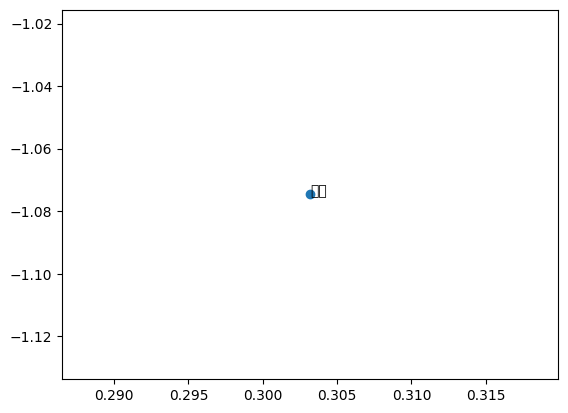

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


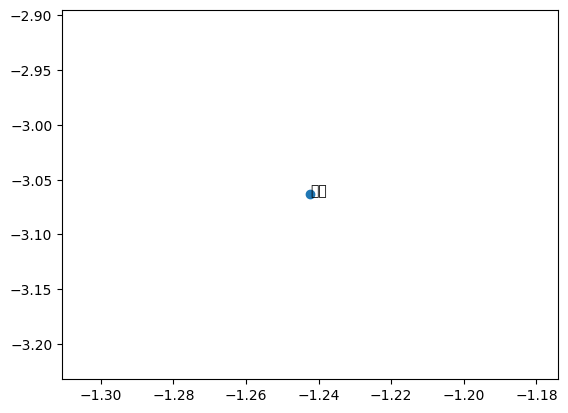

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


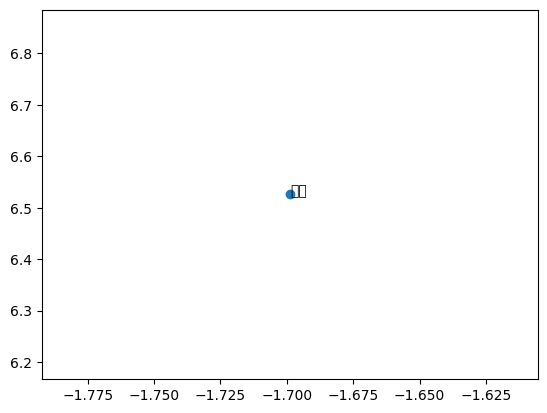

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28982 (\N{CJK UNIFIED IDEOGRAPH-7136}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35821 (\N{CJK UNIFIED IDEOGRAPH-8BED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35328 (\N{CJK UNIFIED IDEOGRAPH-8A00}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


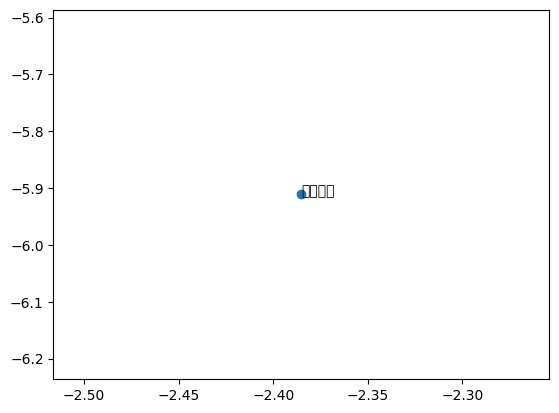

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22788 (\N{CJK UNIFIED IDEOGRAPH-5904}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


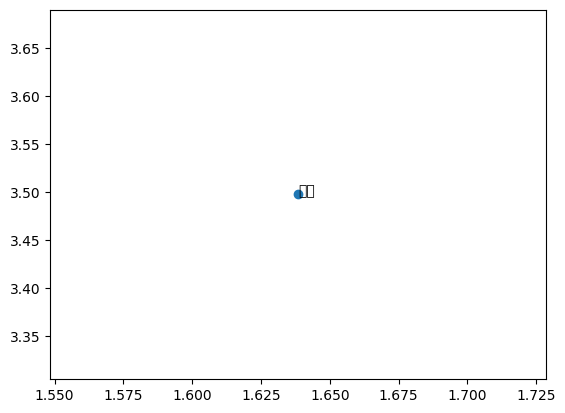

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24456 (\N{CJK UNIFIED IDEOGRAPH-5F88}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


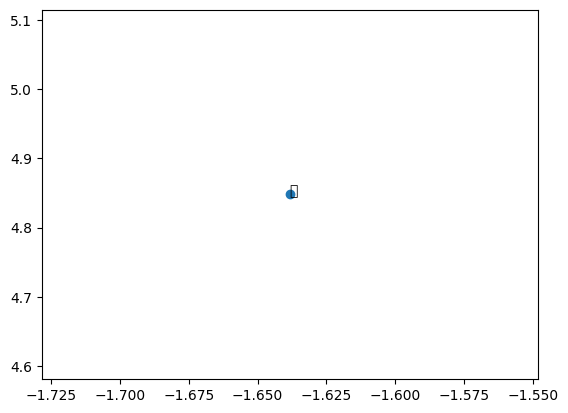

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36259 (\N{CJK UNIFIED IDEOGRAPH-8DA3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


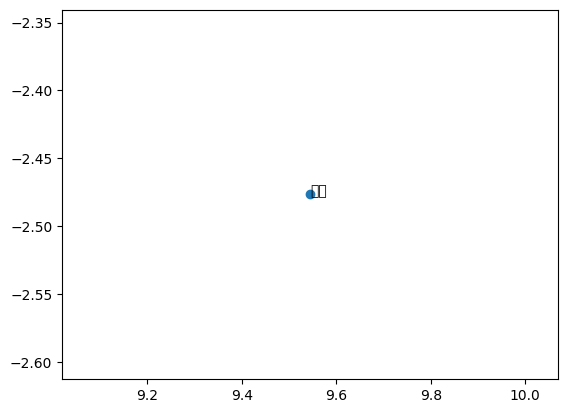

In [10]:
# Extract embeddings
embeddings = model.embeddings.weight.data.numpy()

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot embeddings
plt.figure(figsize=(10, 10))
for i, word in enumerate(idx_to_word.values()):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    plt.show()